In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import KernelDensity
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import networkx as nx
from multiprocessing import Pool
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from helpers import sns_styleset
%matplotlib inline

In [2]:
sns_styleset()

In [3]:
# load HC morphologies
swc_list=[]
for HC in [1902,1903,1904,1905,1906]:
    swc=np.loadtxt('./data/HC_swc/HC'+str(HC)+'.swc')
    swc=pd.DataFrame(swc,columns=['node','type','x','y','z','r','parent'])
    swc_list.append(swc)

In [4]:
M=np.loadtxt('./data/coordinate_rotation')

In [5]:
for j in range(len(swc_list)):
    swc_list[j].loc[0,'par_dist']=0
    for i in range(1,len(swc_list[j])):
        swc_list[j].loc[i,'par_dist']=np.sqrt((swc_list[j].loc[i,'x']-swc_list[j].loc[swc_list[j].loc[i,'parent']-1,'x'])**2+\
                                         (swc_list[j].loc[i,'y']-swc_list[j].loc[swc_list[j].loc[i,'parent']-1,'y'])**2+\
                                         (swc_list[j].loc[i,'z']-swc_list[j].loc[swc_list[j].loc[i,'parent']-1,'z'])**2)

In [6]:
HC_list=[1902,1903,1904,1905,1906]
#minimum and sizes of image stacks
min_list=([818, 198, -62],[832, -6, -52],[863,  45, 108],[846, 375, -58],[834,  -9, -61])
size_list=([ 435, 1957, 1497],[ 393, 1351, 1490],[ 378, 2076, 1328],[ 359, 1904, 1252],[ 346, 1324, 1313])

In [7]:
# create a graph from swx data using networkX
def get_graph(swc):

    n = swc['node'].values 
    scaling = 1 # scaling to get from current coordinates into microns.

    pos = np.array([swc['x'].values, swc['y'].values, swc['z'].values]).T / scaling

    radius = swc['r'].values / scaling # radius of the node. Optional

    t = swc['type'].values  # type of the neuron part: 1: soma, 2: axon, 3: dendrite, Optional

    pid = swc['parent'].values


    # create node data (Kick whatever info you don't need)
    node_keys = ['pos', 'type', 'r']
    node_data = list(zip(n, [dict(zip(node_keys, [pos[ix], t[ix], radius[ix]])) for ix in range(pos.shape[0])]))

    # create edge data
    n_ = n.tolist()
    parent_idx = [n_.index(pid[ix]) for ix in range(1,len(pid))]
    ec = np.sqrt(np.sum((pos[parent_idx] - pos[1:]) ** 2, axis=1)) # euclidean distance btw two connected nodes
    edge_keys = ['euclidean_dist']

    edge_data = list(zip(pid[1:], n[1:],
                         [dict(zip(edge_keys, [ec[ix]])) for ix in range(ec.shape[0])]))

    G = nx.Graph()
    G.add_nodes_from(node_data)
    G.add_edges_from(edge_data)
    return G

def get_tips(G):
    return np.array([e for e in G if [f for f in G[e] if f>e]==[]])

def get_tip_dist(i,j,tip):
    return nx.shortest_path_length(graphs[i],tip,swc_list[i].loc[j,'node'], weight='euclidean_dist')

In [8]:
def get_rad(node,dist_thresh,k):
    rad_list=[[0,swc_list[k].loc[node-1,'r']]]
    
    
    def get_rad_p(node,dist_p,rad_list):
        p_node=swc_list[k].loc[node-1,'parent']
        dist_p+=swc_list[k].loc[node-1,'par_dist']
        rad_list=[[-dist_p,swc_list[k].loc[p_node-1,'r']]]+rad_list
        if (dist_p<dist_thresh)&(p_node>1):
            rad_list=get_rad_p(p_node,dist_p,rad_list)
        return(rad_list)
            
    def get_rad_c(node,dist_c,rad_list):
        children=swc_list[k][swc_list[k]['parent']==node]['node'].values
        if len(children)>0:
            c_rads=[]
            for c_node in children:
                c_rads.append(swc_list[k].loc[c_node-1,'r'])
            c_node=children[np.argmax(c_rads)]
        
            dist_c+=swc_list[k].loc[c_node-1,'par_dist']
            rad_list=rad_list+[[dist_c,swc_list[k].loc[c_node-1,'r']]]
            if (dist_c<dist_thresh):
                rad_list=get_rad_c(c_node,dist_c,rad_list)
        return(rad_list)
    
    rad_list=get_rad_p(node,0,rad_list)
    rad_list=get_rad_c(node,0,rad_list)
                
    return(np.array(rad_list))

In [9]:
graphs=[]
for skel in swc_list:
    graphs+=[get_graph(skel)]

In [10]:
tips=[]
for graph in graphs:
    tips+=[get_tips(graph)]

In [11]:
for i in range(len(swc_list)):
    for j in range(len(swc_list[i])):
        swc_list[i].loc[j,'soma_dist']=nx.shortest_path_length(graphs[i],1,swc_list[i].loc[j,'node'], weight='euclidean_dist')

In [12]:
# This takes long, set number of CPU cores for Pool according to your resources (here 32)
with Pool(32) as p:
    for i in range(len(swc_list)):
        for j in range(len(swc_list[i])):
            swc_list[i].loc[j,'tip_dist']=min(p.starmap(get_tip_dist,list(zip(i*np.ones(len(tips[i])).astype(int),j*np.ones(len(tips[i])).astype(int),tips[i]))))

In [13]:
bulb_positions=pd.read_csv('./data/HC_bulb_contacts.csv',delimiter=';')[['HC','x','y','z']]

bulb_list=[]
for i in range(5):
    bulbs = np.dot(M,(bulb_positions[bulb_positions['HC']==HC_list[i]][['x','y','z']].values/[3,3,2]).T).T
    #to match bulb positions the offset of the image stacks is needed
    bulbs-=min_list[i] # minimum from image stack
    bulb_df=pd.DataFrame(bulbs,columns=['x','y','z'])
    #size of image stack: [ 378, 2076, 1328]
    bulb_df['x_new']=bulb_df['z']
    bulb_df['y_new']=size_list[i][1]-bulb_df['y']
    bulb_df['z_new']=bulb_df['x']
    for j in range(len(bulb_df)):
        bulb_df.loc[j,'nearest_node']=np.argmin(np.linalg.norm(swc_list[i][['x','y','z']].values-bulb_df.loc[j,['x_new','y_new','z_new']].values,axis=1))+1
        bulb_df.loc[j,'node_distance']=np.min(np.linalg.norm(swc_list[i][['x','y','z']].values-bulb_df.loc[j,['x_new','y_new','z_new']].values,axis=1))
    bulb_list.append(bulb_df)

In [14]:
# This takes long, set number of CPU cores for Pool according to your resources (here 32)
with Pool(32) as p:
    for i in range(len(swc_list)):
        bulbs_cell=bulb_list[i]['nearest_node'].values.astype(int)
        for j in range(len(swc_list[i])):
            distances=np.array(p.starmap(get_tip_dist,list(zip(i*np.ones(len(bulbs_cell)).astype(int),j*np.ones(len(bulbs_cell)).astype(int),bulbs_cell))))
            distances=distances[distances>0]
            swc_list[i].loc[j,'bulb_dist']=min(distances)

In [15]:
np.random.seed(1234)
random_nodes = []
for i in range(len(bulb_list)):
    random_nodes.append(swc_list[i].iloc[np.random.choice(len(swc_list[i]), len(bulb_list[i]),replace=False),:])

In [16]:
# This takes long, set number of CPU cores for Pool according to your resources (here 32)
with Pool(32) as p:
    for i in range(len(swc_list)):
        randoms_cell=random_nodes[i]['node'].values.astype(int)
        for j in range(len(swc_list[i])):
            distances=np.array(p.starmap(get_tip_dist,list(zip(i*np.ones(len(randoms_cell)).astype(int),j*np.ones(len(randoms_cell)).astype(int),randoms_cell))))
            distances=distances[distances>0]
            swc_list[i].loc[j,'random_dist']=min(distances)

### Figure 3C

In [17]:
bulb_soma_dist=[]
bulb_tip_dist=[]
for k in range(len(swc_list)):
    bulb_soma_dist_cell=[]
    bulb_tip_dist_cell=[]
    for i in range(len(bulb_list[k])):
        bulb_soma_dist_cell.append(swc_list[k][swc_list[k]['node']==bulb_list[k].loc[i,'nearest_node']]['soma_dist'].item())
        bulb_tip_dist_cell.append(swc_list[k][swc_list[k]['node']==bulb_list[k].loc[i,'nearest_node']]['tip_dist'].item())
    bulb_soma_dist.append(np.array(bulb_soma_dist_cell))
    bulb_tip_dist.append(np.array(bulb_tip_dist_cell))   

In [18]:
all_soma_dist=[]
all_tip_dist=[]
for k in range(len(swc_list)):
    all_soma_dist.append(np.array(swc_list[k]['soma_dist']))
    all_tip_dist.append(np.array(swc_list[k]['tip_dist']))

In [19]:
bulb_kde=[]
all_kde=[]
for k in range(len(swc_list)):
    bulb_kde.append(KernelDensity(kernel='epanechnikov',bandwidth=100).fit(np.vstack((bulb_soma_dist[k],bulb_tip_dist[k])).T))
    all_kde.append(KernelDensity(kernel='epanechnikov',bandwidth=100).fit(np.vstack((all_soma_dist[k],all_tip_dist[k])).T))

In [20]:
avg_nodes=[]
for k in range(len(swc_list)):
    num_samples=len(bulb_soma_dist[k])
    nodes=[]
    while True:
        ind=np.random.randint(len(swc_list[k]))
        p=np.random.rand()
        prob=np.exp(bulb_kde[k].score_samples(np.array(swc_list[k].loc[ind,['soma_dist','tip_dist']]).reshape(1,-1)))/(2*np.exp(all_kde[k].score_samples(np.array(swc_list[k].loc[ind,['soma_dist','tip_dist']]).reshape(1,-1))))
        if p<prob:
            nodes.append(swc_list[k].loc[ind,'node'])
        if len(nodes)>=5*num_samples:
            break
    avg_nodes.append(nodes)

In [21]:
bulb_profiles=[]
for k in range(len(swc_list)):
    bulb_profile=[]
    for i in range(len(bulb_list[k])):
        if bulb_list[k].loc[1,'node_distance']<20:
            bulb_profile.append(get_rad(bulb_list[k].loc[i,'nearest_node'],50,k))
    bulb_profiles.append(bulb_profile)

In [22]:
bulb_profiles_agg=[]
for k in range(len(swc_list)):
    bulb_profile_agg=[]
    for i in range(len(bulb_profiles[k])):
        if bulb_profiles[k][i].shape[0]==13:
            bulb_profile_agg.append(bulb_profiles[k][i][:,1])
    bulb_profile_agg=np.array(bulb_profile_agg)
    bulb_profile_agg=pd.DataFrame(bulb_profile_agg,columns=[-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60])
    bulb_profile_agg['cell']=HC_list[k]
    bulb_profile_agg['cell label']='HC '+str(k+1)+', bulbs'
    bulb_profile_agg['group']='bulb'
    bulb_profiles_agg.append(bulb_profile_agg)

In [23]:
avg_profiles=[]
for k in range(len(swc_list)):
    avg_profile=[]
    for node in avg_nodes[k]:
        current_profile=get_rad(node,50,k)
        if len(current_profile)==13:
            avg_profile.append(current_profile[:,1])
    avg_profile_agg=np.array(avg_profile)
    avg_profile=pd.DataFrame(np.array(avg_profile),columns=[-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60])
    avg_profile['cell']=HC_list[k]
    avg_profile['cell label']='HC '+str(k+1)+', random nodes'
    avg_profile['group']='random'
    avg_profiles.append(avg_profile)

In [24]:
bulb_profiles_df=pd.concat(bulb_profiles_agg)
avg_profiles_df=pd.concat(avg_profiles)
all_profiles=pd.concat([bulb_profiles_df,avg_profiles_df])
all_profiles_long=all_profiles.melt(id_vars=['cell','cell label','group'])
all_profiles_long['radius']=all_profiles_long['value']*50

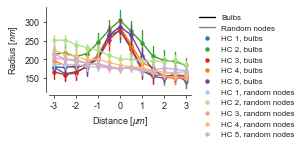

In [25]:
plt.figure(figsize=(6.5/2.54,4/2.54))
sns.pointplot(data=all_profiles_long,x='variable',y='radius',hue='cell label',palette=[sns.color_palette('Paired',10)[i] for i in [1,3,5,7,9,0,2,4,6,8]],label='')
plt.plot(np.arange(-3,-1),200*np.ones(2),c='0',label='Bulbs',linewidth=1.35)
plt.plot(np.arange(-3,-1),200*np.ones(2),c='0.5',label='Random nodes',linewidth=1.35)
plt.xlabel('Distance [$\mu m$]')
plt.ylabel('Radius [$nm$]')
plt.xlim(-0.5,12.5)
plt.xticks([0,2,4,6,8,10,12],[-3,-2,-1,0,1,2,3])
plt.yticks([150,200,250,300])
sns.despine(offset=3)
plt.legend(bbox_to_anchor=(1,1),frameon=False)
# plt.savefig('./figures/Fig3D_HC_dendritic_dia_bulb_vs_random.svg',bbox_inches='tight',dpi=300)  
plt.show()

### Figure 3F

In [26]:
pw_dist_list = []
for i in range(len(bulb_list)):
    pw_dist_list.append(squareform(pdist(bulb_list[i][['x_new', 'y_new', 'z_new']], 'euclidean')))

In [27]:
nearest_bulb_dist = []
for i in range(len(pw_dist_list)):
    for k in range(len(pw_dist_list[i])):
        nearest_bulb_dist.append(np.min(pw_dist_list[i][k][pw_dist_list[i][k]>0]))
nearest_bulb_dist = np.array(nearest_bulb_dist)

In [28]:
pw_dist_list_random = []
for i in range(len(random_nodes)):
    pw_dist_list_random.append(squareform(pdist(random_nodes[i][['x', 'y', 'z']], 'euclidean')))

In [29]:
nearest_random_dist = []
for i in range(len(pw_dist_list_random)):
    for k in range(len(pw_dist_list_random[i])):
        nearest_random_dist.append(np.min(pw_dist_list_random[i][k][pw_dist_list_random[i][k]>0]))
nearest_random_dist = np.array(nearest_random_dist)

In [30]:
bulb_dist_hist = np.histogram(nearest_bulb_dist/20, bins=np.arange(21)*0.75,density=True)
random_dist_hist = np.histogram(nearest_random_dist/20, bins=np.arange(21)*0.75,density=True)

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


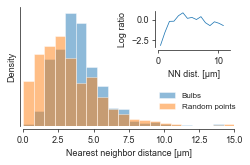

In [31]:
fig,ax = plt.subplots(1,1, figsize=(9/2.54,6/2.54),tight_layout=True)
ax.hist(nearest_bulb_dist/20, bins=np.arange(21)*0.75, alpha=0.5,density=True, label='Bulbs')
ax.hist(nearest_random_dist/20, bins=np.arange(21)*0.75, alpha=0.5,density=True, label='Random points')
plt.legend(loc='lower right', bbox_to_anchor=(1.04,0.08), frameon=False)
axins = inset_axes(ax, width=1.0, height=0.5)
axins.plot(np.arange(15)*0.75+0.375,np.log(bulb_dist_hist[0][:15]/random_dist_hist[0][:15]))
ax.set_yticks([])
ax.set_ylabel('Density')
ax.set_xlabel('Nearest neighbor distance [µm]')
axins.set_xlabel('NN dist. [µm]')
axins.set_ylabel('Log ratio')
ax.set_xlim(0,15)
axins.set_xlim(0,12)
sns.despine(offset=3)
# plt.savefig('./figures/Fig3F_bulb_spatial_distribution.svg',dpi=300)
plt.show()